<p style="text-align: center;">
    МИНОБРНАУКИ РОССИИ <br>
    РГУ НЕФТИ И ГАЗА (НИУ) ИМЕНИ И.М. ГУБКИНА<br>
    ФАКУЛЬТЕТ АВТОМАТИКИ И ВЫЧИСЛИТЕЛЬНОЙ ТЕХНИКИ<br>
    КАФЕДРА АВТОМАТИЗИРОВАННЫХ СИСТЕМ УПРАВЛЕНИЯ<br>
    ДИСЦИПЛИНА <br>
        «Методы и модели оптимизции в автоматизированном управлении НГО»
    <br><br> <br> <br> <br> <br> <br><br>
    ОТЧЁТ <br>
    по лабораторной работе №1 <br>
    «Методы одномерной минимизации»<br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br>
</p>

<p style="text-align: right;">
    Выполнил: студент группы АС-21-05, Негробов В.А.<br>
    Проверила: старший преодаватель, Степанкина О.А.<br><br> <br> <br> <br> <br><br> <br> <br> <br> <br> <br><br><br> <br> <br> <br> <br><br>
</p>

<p style="text-align: center;">
    МОСКВА 2024
</p>

# Предварительная подготовка
Подключение используемых библиотек и модулей:

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from sympy import lambdify, symbols, diff
import sympy
from functools import partial
from utils import plot_convergence_1d, LoggingCallback, plotting
plt.style.use('ggplot')

Создание символьной переменной, необходимой для работы с библиотекой символьного исчисления SymPy:

In [2]:
x_symbol = symbols('x_symbol')
x_symbol

x_symbol

# 1. Выбрать вариант задачи, соответствующий вашему номеру из списка группы.

Нижняя и верхняя граница интервала, начальное положение, точность решения задачи библиотекой SciPy:

In [3]:
lower_bound = 0.1
upper_bound = 1
start_x = (lower_bound + upper_bound) / 2
eps = 1e-8

Создадим символьную функцию, соответствующую варианту:

In [4]:
f_symbol = 10 * x_symbol * sympy.ln(x_symbol) - x_symbol**2 / 2
f_symbol

-x_symbol**2/2 + 10*x_symbol*log(x_symbol)

Первая производная заданной функции:

In [5]:
df_symbol = diff(f_symbol, x_symbol)
df_symbol

-x_symbol + 10*log(x_symbol) + 10

Вторая производная заданной функции:

In [6]:
d2f_symbol = diff(df_symbol, x_symbol)
d2f_symbol

-1 + 10/x_symbol

Преобразование символьных функций в лямбда функции:

In [7]:
f = lambdify(x_symbol, f_symbol, 'numpy')
df = lambdify(x_symbol, df_symbol, 'numpy')
d2f = lambdify(x_symbol, d2f_symbol, 'numpy')

Визуализация функции:

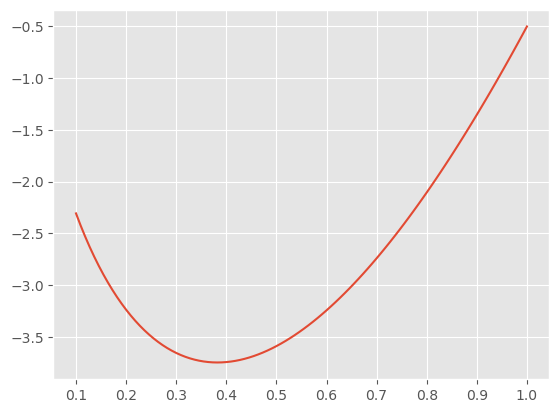

In [8]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.xticks(np.linspace(lower_bound, upper_bound, 10));

Минимизция методом из библиотеки SciPy:

In [9]:
x0 = np.array([start_x])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: -3.749081
         Iterations: 27
         Function evaluations: 54
min x: [0.38221242], f(x) = [-3.74908101]


# 3. Написать скрипты, реализующие следующие методы

## Метод поразрядного поиска (два прохода, p – количество интервалов разбиения начального отрезка) 


In [10]:
def radix_method(func, a, b, p, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    h = (b - a) / p
    x = a
    
    func_x_prev = func(x)
    callback(x, func_x_prev)
    func_x = func(x+h)
    x += h
    callback(x, func_x)
    
    while(func_x < func_x_prev and x < b):
        func_x_prev = func_x
        x +=h
        func_x = func(x)
        callback(x, func_x)
        k += 1
    
    h = eps
    func_x_prev = func_x
    x -= h
    func_x = func(x)
    callback(x, func_x)
    
    while(func_x <= func_x_prev and x > a):
        func_x_prev = func_x
        x -= h
        func_x = func(x)
        callback(x, func_x)
        k += 1
    callback(x + h, f(x + h))
        
    return x + h, k

## Метод Фибоначчи

Реализация функции, вычисляющей числа Фибоначчи, которые не превышают заданное значение и ещё одного:

In [11]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1
    
    yield num1
    
    if num1 > max_value and  num2 > max_value:
        return

    if num1 < max_value and num2 > max_value:
        yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

Метод Фибонначи:

In [12]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib_nums = [num for num in fibonacci_numbers(max_value)]
    length = len(fib_nums) - 1
    y = a + fib_nums[length - 2] / fib_nums[length] * (b - a)
    z = a + fib_nums[length - 1] / fib_nums[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            less = True
            b, z = z, y
            y = a + fib_nums[length - k - 3] / fib_nums[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib_nums[length - k - 2] / fib_nums[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func_y <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

## Метод средней точки

In [13]:
def midpoint_method(func, dfunc, a, b, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    
    interval = b - a
    
    while interval > eps:
        x = (a + b) / 2
        dfunc_x = dfunc(x)
        callback(x, func(x))
        if dfunc_x > 0:
            b = x
        else:
            a = x
        interval /= 2
        k += 1
    return x, k

## Метод Ньютона-Рафсона 

Реализация метода Ньютона, используемого в методе Ньютона-Рафсона:

In [14]:
def newton_method(func, dfunc, d2func, x, eps, max_iter=10_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        d2func_x_inv = 1 / d2func(x) 
        d = -d2func_x_inv * dfunc_x
        x_prev = x
        x = x + d
        
        if np.all(abs(x - x_prev) < eps):
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

Метод Ньютона-Рафсона:

In [15]:
def newton_raphson_method(func, dfunc, d2func, x, eps, lr=1.0,
                          n_eps=0.01, max_iter=10_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)

    def dfi(t, x, d):
        nonlocal dfunc
        return dfunc(x + t * d)

    def d2fi(t, x, d):
        nonlocal d2func
        return d2func(x + t * d)
    
    k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        
        d2func_x_inv = 1 / d2func(x)
        d = -d2func_x_inv * dfunc_x 
        fi_x_d = partial(fi, x=x, d=d)
        dfi_x_d = partial(dfi, x=x, d=d)
        d2fi_x_d = partial(d2fi, x=x, d=d)

        t, _ = newton_method(fi_x_d, dfi_x_d, d2fi_x_d, lr, n_eps, max_iter=1)
        x_prev = x
        x = x + d
        if np.abs(x - x_prev) < eps:
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

## Метод ломанных

In [16]:
def polyline_method(func, dfunc, a, b, eps, callback=None):
    if callback is None:
        callback = lambda c, v: 0 
        
    # L = max(np.abs(dfunc(np.linspace(lower_bound, upper_bound, 1000))))
    def abs_neg_dfunc(x):
        return -np.abs(dfunc(x))
    
    x_min, k = fibonacci_method(abs_neg_dfunc, a, b, 0.001, 0.0005)
    print(f'number of eval in fib: {3 + k}')
    L = np.abs(dfunc(x_min))
    
    k = 0
    func_eval = 0

    func_a = func(a)
    func_b = func(b)
    x = 1 / 2 / L * (func_a - func_b + L * (a + b))
    p = 0.5 * (func_a + func_b + L * (a - b))
    
    callback(x, func(x))

    d = 1 / 2 / L * (f(x) - p)
    while 2 * L * d > eps:
        callback(x, func(x))
        x1 = x - d
        x2 = x + d

        func_eval += 2
        func_x1 = func(x1)
        func_x2 = func(x2)
        if func_x1 < func_x2:
            x = x1
            func_x = func_x1
        else:
            x = x2
            func_x = func_x2
        p = 0.5 * (func_x + p)
        d = 0.5 / L * (func_x - p)
        k += 1
    callback(x, func(x))
    return x, k

# 4. Изучить зависимость количества итераций от точности ($Ɛ = 10^{-k}$, $k = 1..6$). Сделать визуализацию. 

Вычисление количества итераций, выполняемых методами для заданных значений точности:

In [17]:
iter_number = {'epsilon': [], 'radix_method': [], 'fibonacci_method': [],
               'midpoint_method': [], 'newton_raphson_method': [], 'polyline_method': []}

for k in range(1, 6 + 1):
    eps = 10**(-k)
    iter_number['epsilon'].append(f'1e-{k}')
    iter_number['radix_method'].append(radix_method(f, lower_bound, upper_bound, 180*2*k, eps)[1])
    iter_number['fibonacci_method'].append(fibonacci_method(f, a=0.1, b=1, interval_length=eps, eps=eps/2)[1])
    iter_number['midpoint_method'].append(midpoint_method(f, df, lower_bound, upper_bound, eps)[1])
    iter_number['newton_raphson_method'].append(newton_raphson_method(f, df, d2f, x0, eps)[1])
    iter_number['polyline_method'].append(polyline_method(f, df, lower_bound, upper_bound, eps)[1])
df_iter_number = pd.DataFrame(iter_number)
df_iter_number = df_iter_number.set_index('epsilon')
df_iter_number

number of eval in fib: 15
number of eval in fib: 15
number of eval in fib: 15
number of eval in fib: 15
number of eval in fib: 15
number of eval in fib: 15


,radix_method,fibonacci_method,midpoint_method,newton_raphson_method,polyline_method
epsilon,,,,,
1e-1,113,3,4,2,5
1e-2,226,8,7,3,8
1e-3,340,12,10,4,11
1e-4,461,17,14,4,15
1e-5,593,22,17,4,18
1e-6,965,27,20,5,21


Визуализация количества итераций, необходимых методу поразрядного поиска:

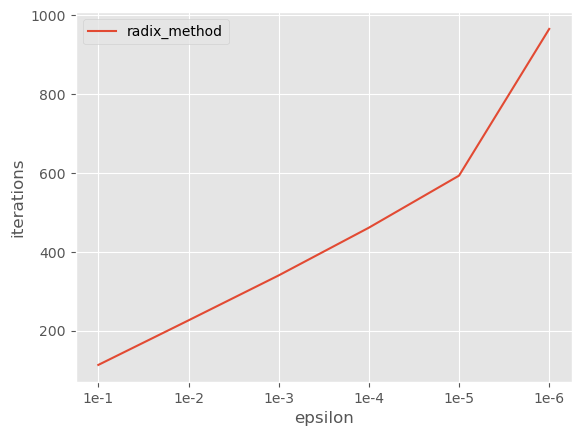

In [18]:
plt.plot(range(6), iter_number['radix_method'], label='radix_method')
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('iterations')
plt.xticks(range(6), [f'1e-{k}' for k in range(1, 7)]);

Визуализация количества итераций, необходимых остальным методам:

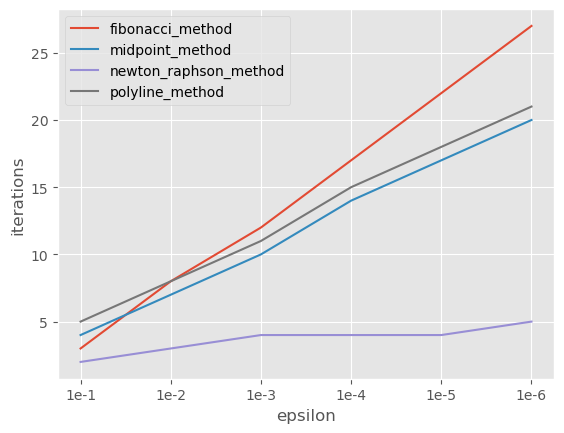

In [19]:
try:
    iter_number.pop('radix_method')
    iter_number.pop('epsilon')
except KeyError:
    print('elements was deleted')

for method, iters in iter_number.items():
    plt.plot(range(6), iters, label=method)
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('iterations')
plt.xticks(range(6), [f'1e-{k}' for k in range(1, 7)]);

# 5. Для методов и точности $Ɛ = 10^{-k}$ по вариантам ($k = 2..6$) привести количество вычислений функции и производных. Результаты разместить в таблице. Построить графики функции и точек приближений к решению. 


Заданная точность:

In [20]:
eps = 1e-4

Подсчёт количества итераций:

In [21]:
xr, kr = radix_method(f, lower_bound, upper_bound, 180, eps)
xf, kf = fibonacci_method(f, a=0.1, b=1, interval_length=eps, eps=eps/2)
xm, km = midpoint_method(f, df, lower_bound, upper_bound, eps)
xn, kn = newton_raphson_method(f, df, d2f, x0, eps)
xp, kp = polyline_method(f, df, lower_bound, upper_bound, eps)

Количество вычислений функции и её производных:

In [23]:
eval_number = {'method': ['f evals', 'df evals', 'd2f evals'],
               'radix_method': [3 + kr, 0, 0],
               'fibonacci_method': [3 + kf, 0, 0],
               'midpoint_method': [0, km, 0],
               'newton_raphson_method': [0, 2 * kn, 2 * kn],
               'polyline_method': [2 + 2 * kp, 15, 0]}

df_eval_number = pd.DataFrame(eval_number)
df_eval_number = df_eval_number.set_index('method')
df_eval_number.T

method,f evals,df evals,d2f evals
radix_method,87,0,0
fibonacci_method,20,0,0
midpoint_method,0,14,0
newton_raphson_method,0,8,8
polyline_method,32,15,0


Визуализация приближений:

number of eval in fib: 15


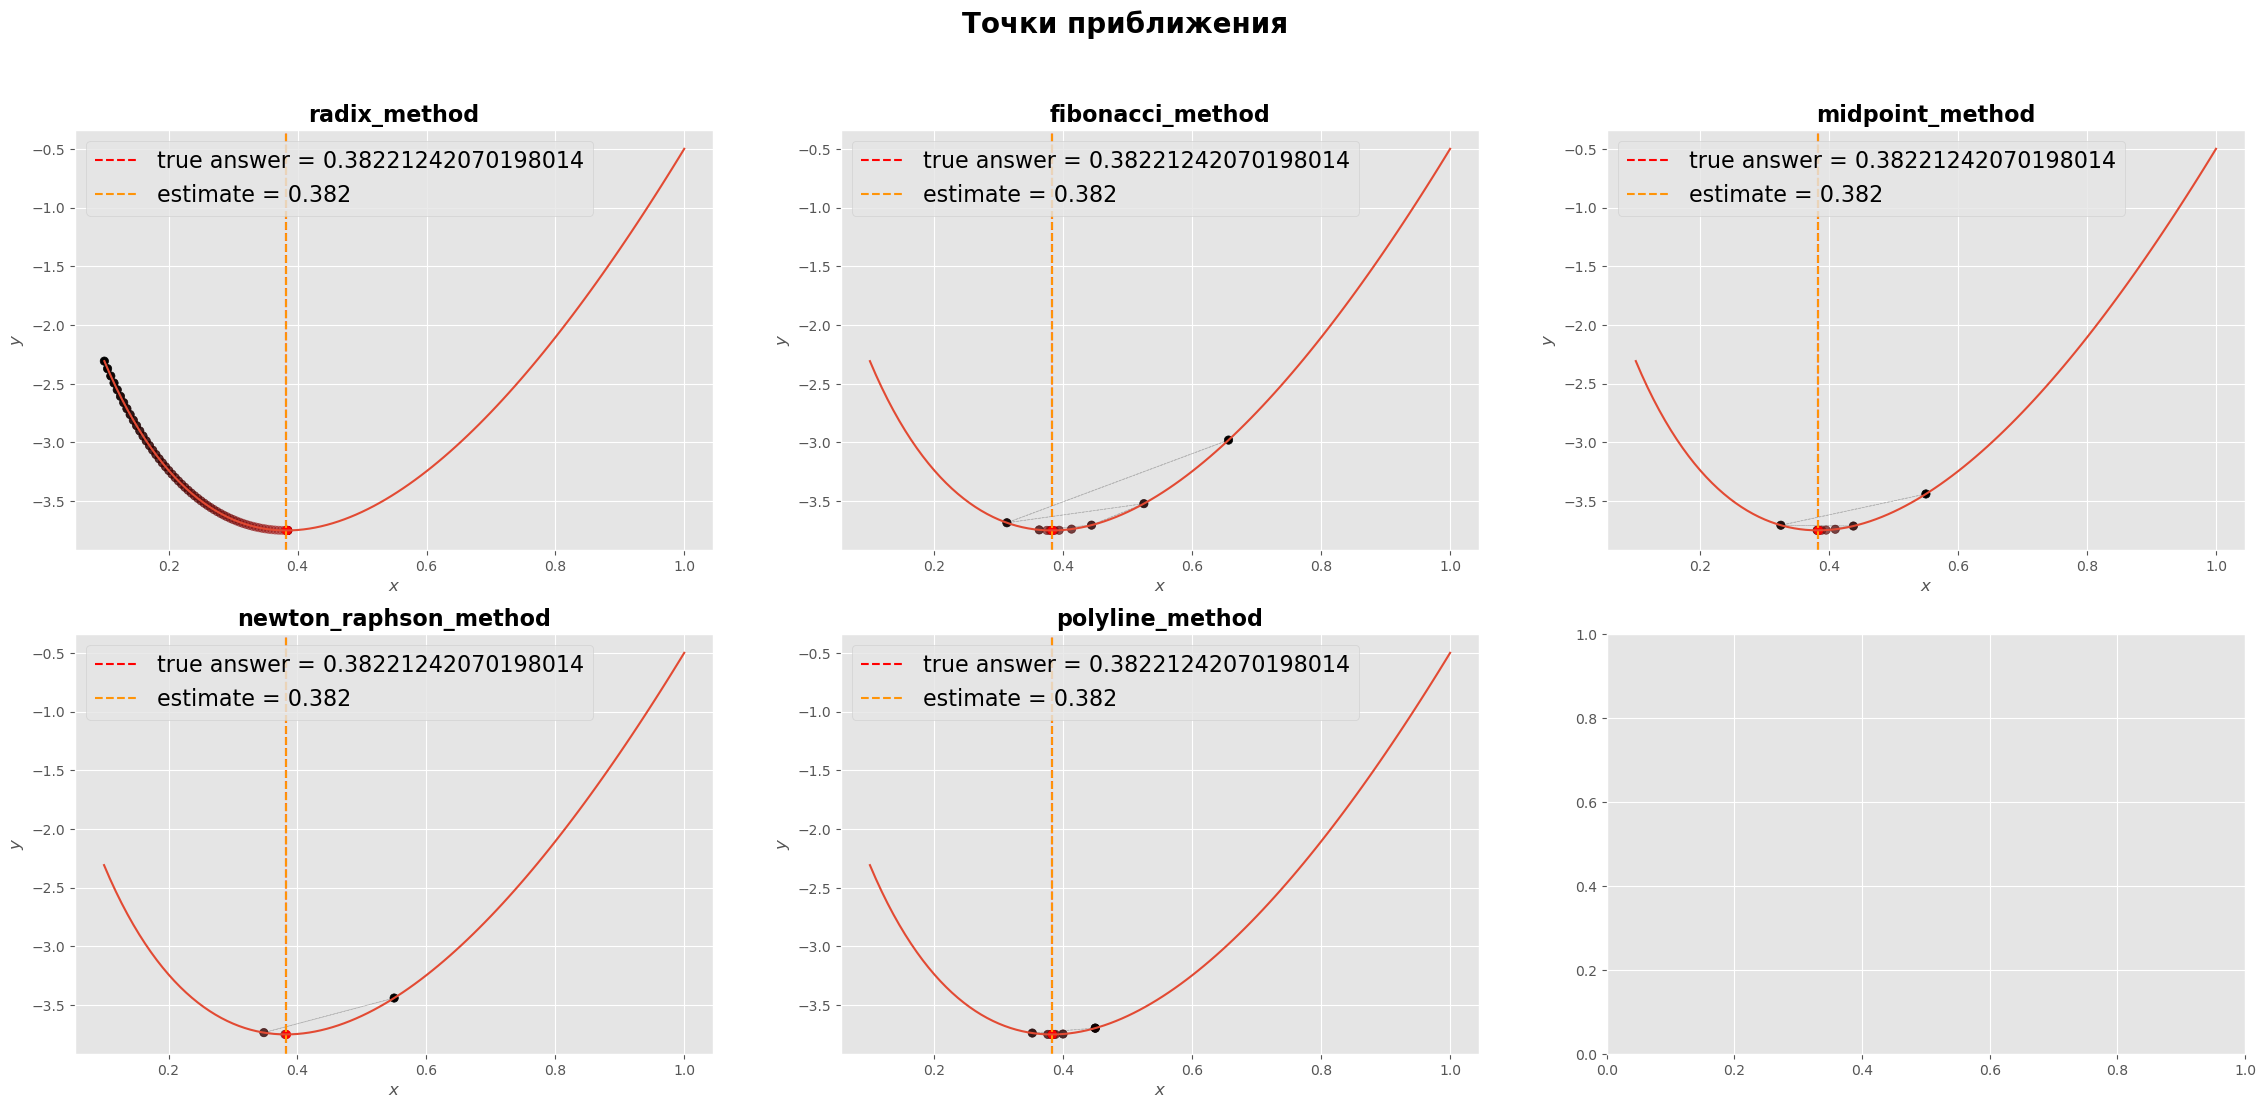

In [24]:
fig, axes = plt.subplots(2,3, figsize=(28, 12))
fig.suptitle("Точки приближения", fontweight="bold", fontsize=20)
grid = np.linspace(lower_bound, upper_bound, 100)


callback = LoggingCallback()  # Не забываем про логирование
radix_method(f, lower_bound, upper_bound, 180, eps, callback=callback)
plotting(axes, 0, res.x[0], callback, grid, f, 'radix_method')

callback = LoggingCallback()
fibonacci_method(f, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, res.x[0], callback, grid, f, 'fibonacci_method')

callback = LoggingCallback()
midpoint_method(f, df, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 2, res.x[0], callback, grid, f, 'midpoint_method')

callback = LoggingCallback()
newton_raphson_method(f, df, d2f, start_x, eps, eps, callback=callback)
plotting(axes, 3, res.x[0], callback, grid, f, 'newton_raphson_method')

callback = LoggingCallback()
polyline_method(f, df, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 4, res.x[0], callback, grid, f, 'polyline_method')

# 6. Найти минимум функции

Создание символьное выражение

In [25]:
f_symbol = sympy.exp(x_symbol) - 1 - x_symbol - x_symbol**2 / 2 - x_symbol**3 / 6
f_symbol

-x_symbol**3/6 - x_symbol**2/2 - x_symbol + exp(x_symbol) - 1

Преобразуем символьное выражение к лямбда функции:

In [26]:
f = lambdify(x_symbol, f_symbol, 'numpy')

Зададим границы поиска мимимума функции:

In [28]:
lower_bound = -5
upper_bound = 5
eps = 1e-4

Визуализация функции:

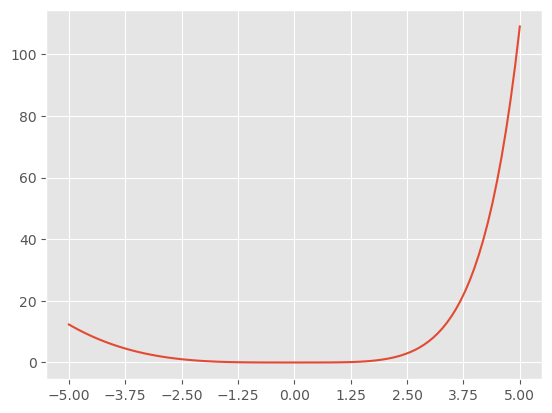

In [29]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.xticks(np.linspace(lower_bound, upper_bound, 9));

Минимизация функции методом библиотеки SciPy:

In [30]:
x0 = np.array([1])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 35
min x: [-8.8817842e-16], f(x) = [0.]


Нахождение минимума функции и необходимого для минимизации с заданной точностью количества итераций методом поразрядного поиска и методом Фибонначи:

In [31]:
radix_method(f, lower_bound, upper_bound, 400, eps)

(0.00010000000000392072, 449)

In [32]:
fibonacci_method(f, a=lower_bound, b=upper_bound, interval_length=eps, eps=eps/2)

(-0.00018094268203260635, 22)

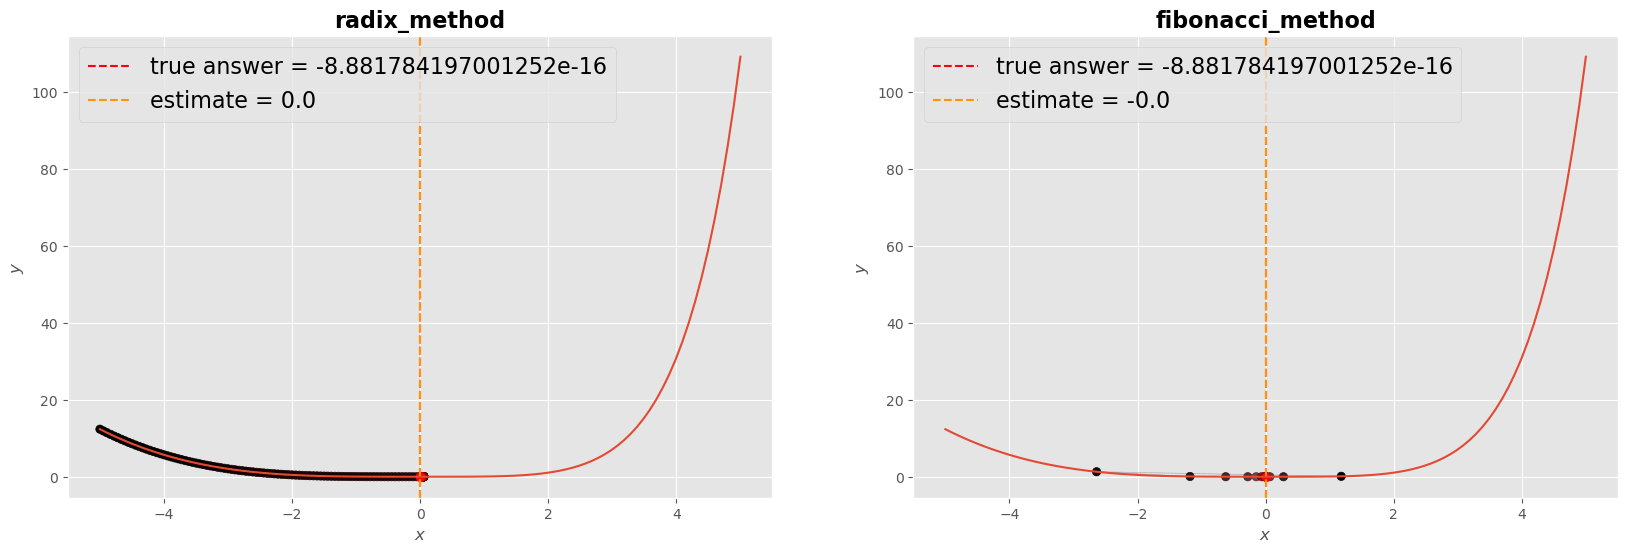

In [33]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))
grid = np.linspace(lower_bound, upper_bound, 100)

callback = LoggingCallback()
radix_method(f, lower_bound, upper_bound, 180, eps, callback=callback)
plotting(axes, 0, res.x[0], callback, grid, f, 'radix_method')

callback = LoggingCallback()
fibonacci_method(f, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, res.x[0], callback, grid, f, 'fibonacci_method')

# 7. Решить задачу минимизации методом Ньютона и его модификациями (по вариантам)

Заданная функция, записанная в виде символьного выражения:

In [34]:
f_symbol = x_symbol * sympy.atan(x_symbol) - 0.5 * sympy.log(1 + x_symbol**2)
f_symbol

x_symbol*atan(x_symbol) - 0.5*log(x_symbol**2 + 1)

Первая производная заданной функции:

In [36]:
df_symbol = diff(f_symbol, x_symbol)
df_symbol

atan(x_symbol)

Вторая производная заданной функции:

In [37]:
d2f_symbol = diff(df_symbol, x_symbol)
d2f_symbol

1/(x_symbol**2 + 1)

Преобразование символьных функций к лямбда-функциям:

In [38]:
f = lambdify(x_symbol, f_symbol, 'numpy')
df = lambdify(x_symbol, df_symbol, 'numpy')
d2f = lambdify(x_symbol, d2f_symbol, 'numpy')

Задание начальных значений, начального приближения, точности решения:

In [44]:
lower_bound = -2
upper_bound = 2
x_start = 1
eps = 1e-4

Визуализация заданной функции:

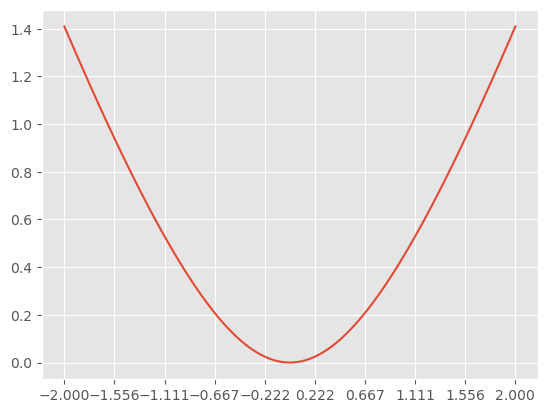

In [45]:
plt.plot((x:=np.linspace(lower_bound, upper_bound, 100)), f(x))
plt.xticks(np.linspace(lower_bound, upper_bound, 10));

Решение задачи минимизации методом библиотеки SciPy:

In [46]:
x0 = np.array([x_start])
res = minimize(f, x0, method='nelder-mead',
               options={'xatol': eps, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
min x: [-8.8817842e-16], f(x) = [7.88860905e-31]


Решение задачи методом Ньютона-Рафсона, необходимое для решения количество итераций:

In [47]:
newton_raphson_method(f, df, d2f, x_start, eps, eps)

(0.0, 5)

Визуализаций приближений, полученных в ходе решения:

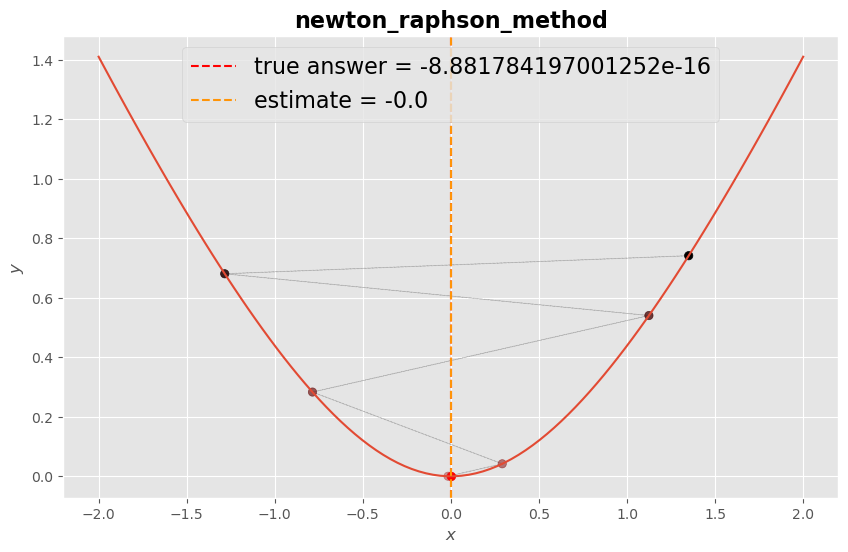

In [49]:
fig, axes = plt.subplots(figsize=(10, 6))
grid = np.linspace(lower_bound, upper_bound, 100)
callback = LoggingCallback()
newton_raphson_method(f, df, d2f, 1.35, eps, eps, callback=callback)
plotting(np.array(axes), 0, res.x[0], callback, grid, f, 'newton_raphson_method')

# Вывод

Метод поразрядного поиска выполняет большое количество итераций, при этом не требует дифференцируемости функции. Его преимуществами является возможность поиска минимума на любых участках функции и на любом интервале.
Метод Фибоначчи является методом нулевого порядка, который способен относительно быстро найти минимум функции.
Метод средней точки использует информацию только о производной функции, которая вычисляется 1 раз за итерацию. Также он достаточно быстро сходится, так как каждый раз отрезок, на котором находится точка минимума, уменьшается в 2 раза.
Метод Ньютона-Рафсона является самым быстро сходящимся методом, но при этом он требует знание функции, её первой и второй производной, получение которых может быть затруднительным.
Метод ломаных выполняет по 2 вычисления функции на итерации, требует знание функции и постоянной Липшица этой функции. В целом, он способен выполнять минимизацию многомодальных функций, поэтому мало смысла применять его для минимизации унимодальных функций.
Методы нулевого порядка могут испытывать проблемы нахождения минимума функции, если он находится на плато. По сравнению с методом поразрядного поиска, метод Фибоначчи выигрывает в решении таких задач.
Метод Ньютона-Рафсона является самым быстро сходящимся, но при этом его стоит использовать только вблизи минимума функции, так как он имеет свойство притягиваться ко всем экстремумам, максимумам в том числе. Также, в случае, если вторая производная на порядок меньше первой, то метод может не сойтись в целом.